In [1]:
# Where we will load the h5ad file
results_directory = '../data/'

In [2]:
# Load the relevant packages.
# First load the packages.
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import scanorama as scrama
from scipy import sparse

sc.settings.verbosity = 3 # Possible values: (0) errors, (1) warnings, (2) info, (3) hints
sc.settings.set_figure_params(dpi = 100, facecolor='white', fontsize=18, transparent=True)

In [3]:
# Save so we don't lose all the good work from Scanorama.
init_results_name = 'integratedskindata.h5ad'
wound_full_merged = sc.read_h5ad(results_directory + init_results_name)

Subset the integrated data for the various major cell types for further subclustering.

In [4]:
epidermis_merged = wound_full_merged[wound_full_merged.obs['leiden'].str.startswith('EPI')]
fibroblast_merged = wound_full_merged[wound_full_merged.obs['leiden'].str.startswith('FIB')]
immune_merged = wound_full_merged[wound_full_merged.obs['leiden'].str.startswith('IMM')]
endothelial_merged = wound_full_merged[wound_full_merged.obs['leiden'].str.startswith('ENDO')]
pericyte_merged = wound_full_merged[wound_full_merged.obs['leiden'].str.startswith('PERI')]
schwann_merged = wound_full_merged[wound_full_merged.obs['leiden'].str.startswith('SCH')]

In [5]:
wound_full_merged.obs.leiden.cat.categories

Index(['EPI-1', 'FIB-1', 'FIB-2', 'EPI-2', 'IMM-1', 'FIB-3', 'PERI', 'IMM-2',
       'EPI-3', 'ENDO', 'EPI-4', 'SCH', 'FIB-4', 'LYM-E', 'EPI-5', 'IMM-3',
       'MEL', 'LC', 'SKEL', 'SMC'],
      dtype='object')

In [6]:
wound_full_merged

AnnData object with n_obs × n_vars = 107778 × 21485
    obs: 'sample', 'sub_sample', 'doublet_score', 'predicted_doublet', 'batch', 'n_counts', 'log_counts', 'n_genes', 'pct_counts_mt', 'leiden', 'leiden_sub', 'Cell cycle', 'S_score', 'G2M_score', 'phase'
    var: 'gene_ids-0', 'n_cells-0', 'gene_ids-1', 'n_cells-1', 'gene_ids-2', 'n_cells-2', 'gene_ids-3', 'n_cells-3', 'gene_ids-4', 'n_cells-4', 'gene_ids-5', 'n_cells-5', 'gene_ids-6', 'n_cells-6', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg', 'leiden', 'leiden_colors', 'leiden_sub_colors', 'neighbors', 'sample_colors', 'umap'
    obsm: 'X_SC', 'X_umap'
    layers: 'counts', 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

In [7]:
sc.settings.set_figure_params(dpi=120, fontsize=12, frameon=False)

In [8]:
wound_full_merged.obs['leiden'] = wound_full_merged.obs['leiden'].cat.reorder_categories(['EPI-1',
                                                       'EPI-2',
                                                       'EPI-3',
                                                       'EPI-4',
                                                       'EPI-5',
                                                       'FIB-1',
                                                       'FIB-2',
                                                       'FIB-3',
                                                       'FIB-4',
                                                       'IMM-1',
                                                       'IMM-2',
                                                       'IMM-3',
                                                       'PERI',
                                                       'ENDO',
                                                       'SCH',
                                                       'LYM-E',
                                                       'MEL',
                                                       'LC',
                                                       'SKEL',
                                                       'SMC'])

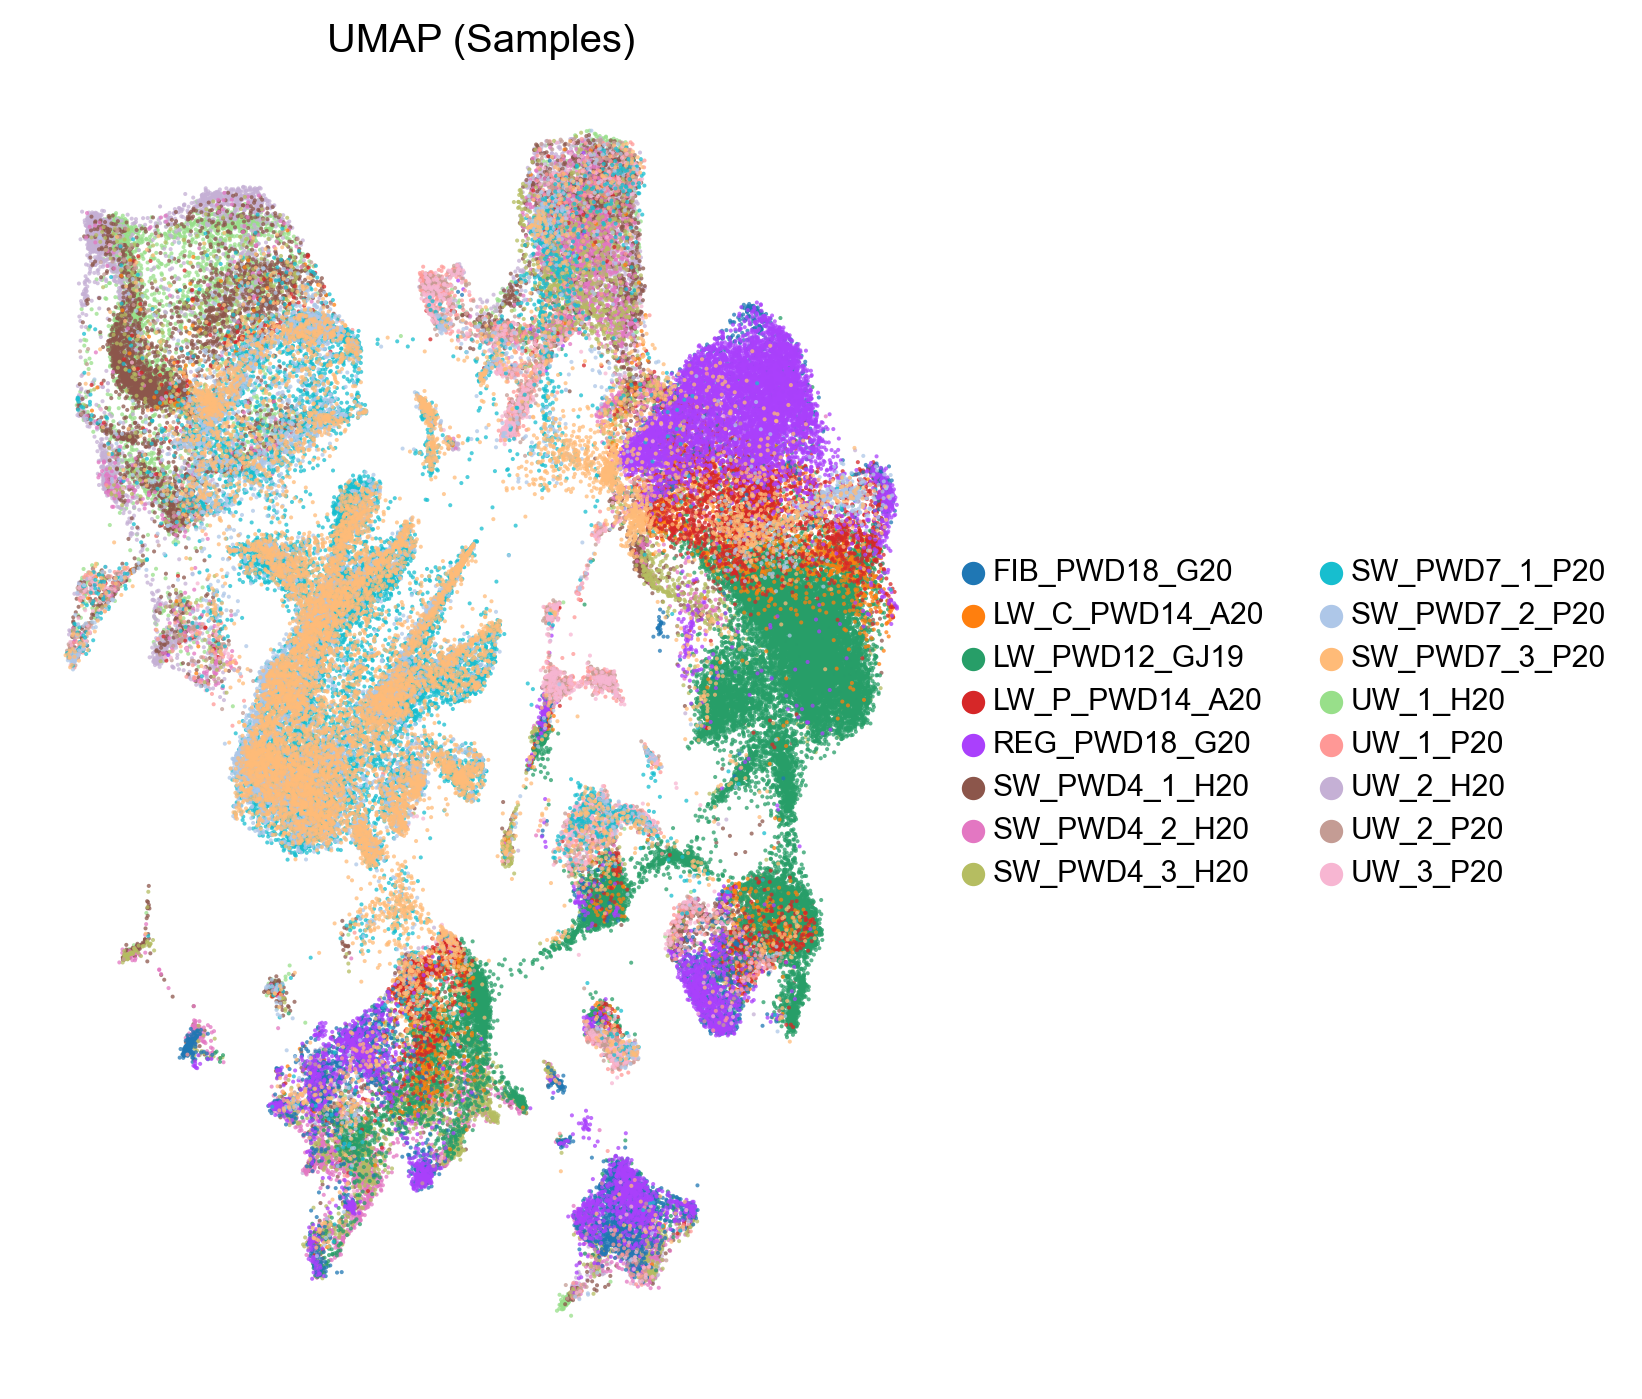

In [11]:
fig, ax = plt.subplots(figsize=(7, 6))
sc.pl.umap(
    wound_full_merged,
    color="sub_sample",
    frameon=False,
    legend_loc="right margin",   # clean legend
    legend_fontsize=9,
    size=6,                      # point size
    alpha=0.75,                  # transparency
    title="UMAP (Samples)",
    show=False,
    ax=ax
)
plt.tight_layout()
plt.show()

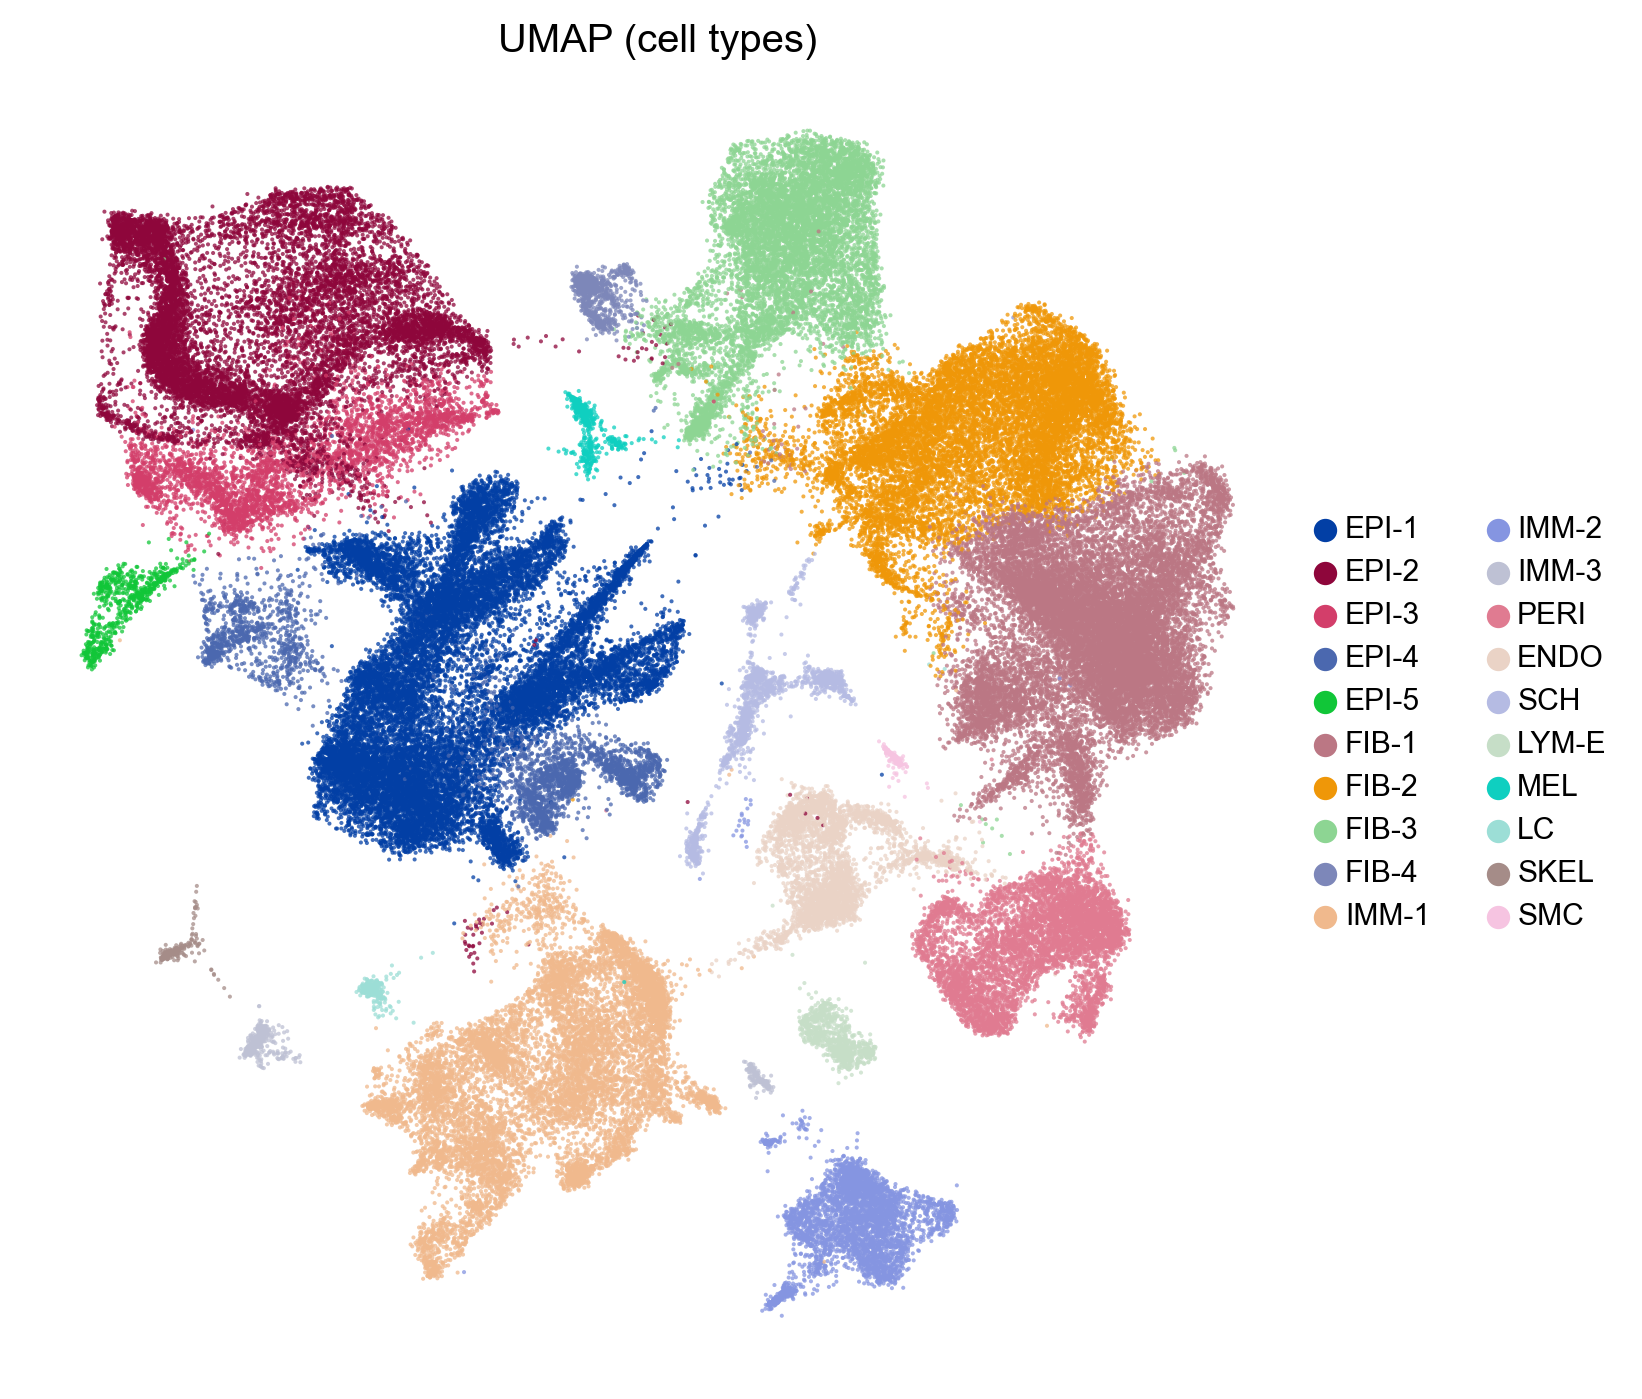

In [10]:
fig, ax = plt.subplots(figsize=(7, 6))
sc.pl.umap(
    wound_full_merged,
    color="leiden",
    frameon=False,
    legend_loc="right margin",   # clean legend
    legend_fontsize=9,
    size=6,                      # point size
    alpha=0.75,                  # transparency
    title="UMAP (cell types)",
    show=False,
    ax=ax
)
plt.tight_layout()
plt.show()

# Subclustering fibroblasts

In [6]:
# Identify the highly-variable genes. We use the CellRanger routine provided in Scanpy.
target_genes = 2000
sc.pp.highly_variable_genes(fibroblast_merged, flavor='cell_ranger', n_top_genes=target_genes, batch_key='sample')

# As we don't have enough target genes, we need to consider HVGs in all but one batches.
n_batches = len(fibroblast_merged.obs['sample'].cat.categories)
# These are the genes that are variable across all batches
nbatch1_dispersions = fibroblast_merged.var['dispersions_norm'][fibroblast_merged.var.highly_variable_nbatches > n_batches - 1]
nbatch1_dispersions.sort_values(ascending=False, inplace=True)
print(len(nbatch1_dispersions))

# Fill up the genes now, using this method from the Theis lab
enough = False
hvg_fibroblast = nbatch1_dispersions.index[:]
not_n_batches = 1

# We'll go down one by one, until we're selecting HVGs from just a single gbatch
while not enough:
    
    target_genes_diff = target_genes - len(hvg_fibroblast) # Get the number of genes we still need to fill up
    
    tmp_dispersions = fibroblast_merged.var['dispersions_norm'][fibroblast_merged.var.highly_variable_nbatches == (n_batches - not_n_batches)]
    
    # If we haven't hit the target gene numbers, add this to the list and we repeat this iteration
    if len(tmp_dispersions) < target_genes_diff:
        
        hvg_fibroblast = hvg_fibroblast.append(tmp_dispersions.index)
        not_n_batches += 1
        
    else:
        
        tmp_dispersions.sort_values(ascending=False, inplace=True)
        hvg_fibroblast = hvg_fibroblast.append(tmp_dispersions.index[:target_genes_diff])
        enough = True

extracting highly variable genes
    finished (0:00:20)


/Users/xhx/miniconda3/envs/pancrearl/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:744: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["hvg"] = {"flavor": flavor}


--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
115


In [7]:
fibroblast_merged_hvg = fibroblast_merged.copy()
fibroblast_merged_hvg = fibroblast_merged_hvg[:, hvg_fibroblast]

In [16]:
fibroblast_merged_hvg

View of AnnData object with n_obs × n_vars = 40087 × 2000
    obs: 'sample', 'sub_sample', 'doublet_score', 'predicted_doublet', 'batch', 'n_counts', 'log_counts', 'n_genes', 'pct_counts_mt', 'leiden', 'leiden_sub', 'Cell cycle', 'S_score', 'G2M_score', 'phase'
    var: 'gene_ids-0', 'n_cells-0', 'gene_ids-1', 'n_cells-1', 'gene_ids-2', 'n_cells-2', 'gene_ids-3', 'n_cells-3', 'gene_ids-4', 'n_cells-4', 'gene_ids-5', 'n_cells-5', 'gene_ids-6', 'n_cells-6', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg', 'leiden', 'neighbors', 'sample_colors', 'umap'
    obsm: 'X_SC', 'X_umap'
    layers: 'counts', 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

In [18]:
fibroblast_merged_hvg.obsm['X_umap'].shape

(40087, 2)

In [8]:
# Split the data into batches (marked by 'sample')
fibroblast_split = []

for sample in fibroblast_merged_hvg.obs['sample'].unique():
    fibroblast_split.append(fibroblast_merged_hvg[fibroblast_merged_hvg.obs['sample']==sample].copy())

In [ ]:
%%time
# Now we run Scanorama on the split data.
scrama.integrate_scanpy(fibroblast_split, ds_names = list(fibroblast_merged_hvg.obs['sample'].unique()))

After UW P49: 2000 genes
After SW PWD4: 2000 genes
After LW PWD12: 2000 genes
After LW PWD14: 2000 genes
After LW FIB PWD18: 2000 genes
After LW REG PWD18: 2000 genes
After UW P21: 2000 genes
After SW PWD7: 2000 genes
Found 2000 genes among all datasets


In [ ]:
embeddings_fibroblast = [adata.obsm['X_scanorama'] for adata in fibroblast_split]
embeddings_fibroblast_joined = np.concatenate(embeddings_fibroblast, axis=0)
fibroblast_merged.obsm['X_SC_FIB'] = embeddings_fibroblast_joined

In [ ]:
# Run PCA just to see the variation across samples
sc.pp.neighbors(fibroblast_merged, use_rep = 'X_SC_FIB', n_neighbors=30)
sc.tl.umap(fibroblast_merged)

We find that we need to recluster the fibroblasts twice, to remove a subset of erythrocytes.

In [ ]:
# Cluster the data now
sc.tl.leiden(fibroblast_merged, resolution = 0.5, key_added = 'leiden_sub')

In [ ]:
fibroblast_merged = fibroblast_merged[fibroblast_merged.obs['leiden_sub'] != '11']

In [ ]:
# Identify the highly-variable genes. We use the CellRanger routine provided in Scanpy.
target_genes = 2000
sc.pp.highly_variable_genes(fibroblast_merged, flavor='cell_ranger', n_top_genes=target_genes, batch_key='sample')

# As we don't have enough target genes, we need to consider HVGs in all but one batches.
n_batches = len(fibroblast_merged.obs['sample'].cat.categories)
# These are the genes that are variable across all batches
nbatch1_dispersions = fibroblast_merged.var['dispersions_norm'][fibroblast_merged.var.highly_variable_nbatches > n_batches - 1]
nbatch1_dispersions.sort_values(ascending=False, inplace=True)
print(len(nbatch1_dispersions))

# Fill up the genes now, using this method from the Theis lab
enough = False
hvg_fibroblast = nbatch1_dispersions.index[:]
not_n_batches = 1

# We'll go down one by one, until we're selecting HVGs from just a single gbatch
while not enough:
    
    target_genes_diff = target_genes - len(hvg_fibroblast) # Get the number of genes we still need to fill up
    
    tmp_dispersions = fibroblast_merged.var['dispersions_norm'][fibroblast_merged.var.highly_variable_nbatches == (n_batches - not_n_batches)]
    
    # If we haven't hit the target gene numbers, add this to the list and we repeat this iteration
    if len(tmp_dispersions) < target_genes_diff:
        
        hvg_fibroblast = hvg_fibroblast.append(tmp_dispersions.index)
        not_n_batches += 1
        
    else:
        
        tmp_dispersions.sort_values(ascending=False, inplace=True)
        hvg_fibroblast = hvg_fibroblast.append(tmp_dispersions.index[:target_genes_diff])
        enough = True

In [ ]:
fibroblast_merged_hvg = fibroblast_merged.copy()
fibroblast_merged_hvg = fibroblast_merged_hvg[:, hvg_fibroblast]

In [ ]:
# Split the data into batches (marked by 'sample')
fibroblast_split = []

for sample in fibroblast_merged_hvg.obs['sample'].unique():
    fibroblast_split.append(fibroblast_merged_hvg[fibroblast_merged_hvg.obs['sample']==sample].copy())

In [ ]:
%%time
# Now we run Scanorama on the split data.
scrama.integrate_scanpy(fibroblast_split, ds_names = list(fibroblast_merged_hvg.obs['sample'].unique()))

In [ ]:
embeddings_fibroblast = [adata.obsm['X_scanorama'] for adata in fibroblast_split]
embeddings_fibroblast_joined = np.concatenate(embeddings_fibroblast, axis=0)
fibroblast_merged.obsm['X_SC_FIB'] = embeddings_fibroblast_joined

In [ ]:
# Run PCA just to see the variation across samples
sc.pp.neighbors(fibroblast_merged, use_rep = 'X_SC_FIB', n_neighbors=30)
sc.tl.umap(fibroblast_merged)

In [ ]:
# Cluster the data now
sc.tl.leiden(fibroblast_merged, resolution = 0.7, key_added = 'leiden_sub')

In [ ]:
sc.tl.rank_genes_groups(fibroblast_merged, 'leiden_sub', key_added = 'leiden_sub', method='wilcoxon')

In [ ]:
# Rename the clusters
fibroblast_cluster_names = ['FIB-I', 'FIB-II', 'FIB-III', 'FIB-IV',\
                            'FIB-V', 'FIB-VI', 'FIB-VII', 'FIB-VIII',
                            'FIB-IX', 'FIB-X', 'FIB-XI']
fibroblast_merged.rename_categories('leiden_sub', fibroblast_cluster_names)

Save the fibroblasts as a separate file for further analysis.

In [ ]:
fibroblasts_file_name = 'integratedfibroblastsdata.h5ad'
fibroblast_merged.write(results_directory + fibroblasts_file_name, compression='gzip')

# Subclustering immune cells

In [ ]:
# Identify the highly-variable genes. We use the CellRanger routine provided in Scanpy.
target_genes = 2000
sc.pp.highly_variable_genes(immune_merged, flavor='cell_ranger', n_top_genes=target_genes, batch_key='sample')

# As we don't have enough target genes, we need to consider HVGs in all but one batches.
n_batches = len(immune_merged.obs['sample'].cat.categories)
# These are the genes that are variable across all batches
nbatch1_dispersions = immune_merged.var['dispersions_norm'][immune_merged.var.highly_variable_nbatches > n_batches - 1]
nbatch1_dispersions.sort_values(ascending=False, inplace=True)
print(len(nbatch1_dispersions))

# Fill up the genes now, using this method from the Theis lab
enough = False
hvg_immune = nbatch1_dispersions.index[:]
not_n_batches = 1

# We'll go down one by one, until we're selecting HVGs from just a single gbatch
while not enough:
    
    target_genes_diff = target_genes - len(hvg_immune) # Get the number of genes we still need to fill up
    
    tmp_dispersions = immune_merged.var['dispersions_norm'][immune_merged.var.highly_variable_nbatches == (n_batches - not_n_batches)]
    
    # If we haven't hit the target gene numbers, add this to the list and we repeat this iteration
    if len(tmp_dispersions) < target_genes_diff:
        
        hvg_immune = hvg_immune.append(tmp_dispersions.index)
        not_n_batches += 1
        
    else:
        
        tmp_dispersions.sort_values(ascending=False, inplace=True)
        hvg_immune = hvg_immune.append(tmp_dispersions.index[:target_genes_diff])
        enough = True

In [ ]:
immune_merged_hvg = immune_merged.copy()
immune_merged_hvg = immune_merged_hvg[:, hvg_immune]

In [ ]:
# Split the data into batches (marked by 'sample')
immune_split = []

for sample in immune_merged_hvg.obs['sample'].unique():
    immune_split.append(immune_merged_hvg[immune_merged_hvg.obs['sample']==sample].copy())

In [ ]:
%%time
# Now we run Scanorama on the split data. (I find that we don't really need the batch-corrected data for these datasets)
scrama.integrate_scanpy(immune_split, ds_names = list(immune_merged_hvg.obs['sample'].unique()))

In [ ]:
embeddings_immune = [adata.obsm['X_scanorama'] for adata in immune_split]
embeddings_immune_joined = np.concatenate(embeddings_immune, axis=0)
immune_merged.obsm['X_SC_IMM'] = embeddings_immune_joined

In [ ]:
sc.pp.neighbors(immune_merged, use_rep = 'X_SC_IMM', n_neighbors=30)
sc.tl.umap(immune_merged)

In [ ]:
# Cluster the data now
sc.tl.leiden(immune_merged, resolution = 0.4, key_added = 'leiden_sub')

In [ ]:
sc.tl.rank_genes_groups(immune_merged, 'leiden_sub', key_added = 'leiden_sub', method='wilcoxon')

Cluster 13 is Erythrocytes, so let's remove them

In [ ]:
immune_merged = immune_merged[immune_merged.obs['leiden_sub'] != '13']

Rerun the integration again

In [ ]:
# Identify the highly-variable genes. We use the CellRanger routine provided in Scanpy.
target_genes = 2000
sc.pp.highly_variable_genes(immune_merged, flavor='cell_ranger', n_top_genes=target_genes, batch_key='sample')

# As we don't have enough target genes, we need to consider HVGs in all but one batches.
n_batches = len(immune_merged.obs['sample'].cat.categories)
# These are the genes that are variable across all batches
nbatch1_dispersions = immune_merged.var['dispersions_norm'][immune_merged.var.highly_variable_nbatches > n_batches - 1]
nbatch1_dispersions.sort_values(ascending=False, inplace=True)
print(len(nbatch1_dispersions))

# Fill up the genes now, using this method from the Theis lab
enough = False
hvg_immune = nbatch1_dispersions.index[:]
not_n_batches = 1

# We'll go down one by one, until we're selecting HVGs from just a single gbatch
while not enough:
    
    target_genes_diff = target_genes - len(hvg_immune) # Get the number of genes we still need to fill up
    
    tmp_dispersions = immune_merged.var['dispersions_norm'][immune_merged.var.highly_variable_nbatches == (n_batches - not_n_batches)]
    
    # If we haven't hit the target gene numbers, add this to the list and we repeat this iteration
    if len(tmp_dispersions) < target_genes_diff:
        
        hvg_immune = hvg_immune.append(tmp_dispersions.index)
        not_n_batches += 1
        
    else:
        
        tmp_dispersions.sort_values(ascending=False, inplace=True)
        hvg_immune = hvg_immune.append(tmp_dispersions.index[:target_genes_diff])
        enough = True

In [ ]:
immune_merged_hvg = immune_merged.copy()
immune_merged_hvg = immune_merged_hvg[:, hvg_immune]

In [ ]:
# Split the data into batches (marked by 'sample')
immune_split = []

for sample in immune_merged_hvg.obs['sample'].unique():
    immune_split.append(immune_merged_hvg[immune_merged_hvg.obs['sample']==sample].copy())

In [ ]:
%%time
# Now we run Scanorama on the split data. (I find that we don't really need the batch-corrected data for these datasets)
scrama.integrate_scanpy(immune_split, ds_names = list(immune_merged_hvg.obs['sample'].unique()))

In [ ]:
embeddings_immune = [adata.obsm['X_scanorama'] for adata in immune_split]
embeddings_immune_joined = np.concatenate(embeddings_immune, axis=0)
immune_merged.obsm['X_SC_IMM'] = embeddings_immune_joined

In [ ]:
sc.pp.neighbors(immune_merged, use_rep = 'X_SC_IMM', n_neighbors=30)
sc.tl.umap(immune_merged)

In [ ]:
# Cluster the data now
sc.tl.leiden(immune_merged, resolution = 0.3, key_added = 'leiden_sub')

In [ ]:
sc.tl.rank_genes_groups(immune_merged, 'leiden_sub', key_added = 'leiden_sub', method='wilcoxon')

In [ ]:
# Rename the clusters
immune_cluster_names = ['MAC-1', 'TCELL', 'DC-1', 'MAC-2',\
                        'MAC-3', 'DC-2', 'DC-3', 'NEU',\
                        'MAC-4', 'MAC-5', 'NK', 'BASO', 'pDC',\
                        'MAST']
immune_merged.rename_categories('leiden_sub', immune_cluster_names)

## Subcluster T cells

In [ ]:
tcells_merged = immune_merged[immune_merged.obs['leiden_sub'].str.startswith('TCELL')].copy()

In [ ]:
# Identify the highly-variable genes. We use the CellRanger routine provided in Scanpy.
target_genes = 2000
sc.pp.highly_variable_genes(tcells_merged, flavor='cell_ranger', n_top_genes=target_genes, batch_key='sample')

# As we don't have enough target genes, we need to consider HVGs in all but one batches.
n_batches = len(tcells_merged.obs['sample'].cat.categories)
# These are the genes that are variable across all batches
nbatch1_dispersions = tcells_merged.var['dispersions_norm'][tcells_merged.var.highly_variable_nbatches > n_batches - 1]
nbatch1_dispersions.sort_values(ascending=False, inplace=True)
print(len(nbatch1_dispersions))

# Fill up the genes now, using this method from the Theis lab
enough = False
hvg_tcells = nbatch1_dispersions.index[:]
not_n_batches = 1

# We'll go down one by one, until we're selecting HVGs from just a single gbatch
while not enough:
    
    target_genes_diff = target_genes - len(hvg_tcells) # Get the number of genes we still need to fill up
    
    tmp_dispersions = tcells_merged.var['dispersions_norm'][tcells_merged.var.highly_variable_nbatches == (n_batches - not_n_batches)]
    
    # If we haven't hit the target gene numbers, add this to the list and we repeat this iteration
    if len(tmp_dispersions) < target_genes_diff:
        
        hvg_tcells = hvg_tcells.append(tmp_dispersions.index)
        not_n_batches += 1
        
    else:
        
        tmp_dispersions.sort_values(ascending=False, inplace=True)
        hvg_tcells = hvg_tcells.append(tmp_dispersions.index[:target_genes_diff])
        enough = True

In [ ]:
tcells_merged_hvg = tcells_merged.copy()
tcells_merged_hvg = tcells_merged_hvg[:, hvg_tcells]

In [ ]:
# Split the data into batches (marked by 'sample')
tcells_split = []

for sample in tcells_merged_hvg.obs['sample'].unique():
    tcells_split.append(tcells_merged_hvg[tcells_merged_hvg.obs['sample']==sample].copy())

In [ ]:
%%time
# Now we run Scanorama on the split data. (I find that we don't really need the batch-corrected data for these datasets)
scrama.integrate_scanpy(tcells_split, ds_names = list(tcells_merged_hvg.obs['sample'].unique()))

In [ ]:
embeddings_tcells = [adata.obsm['X_scanorama'] for adata in tcells_split]
embeddings_tcells_joined = np.concatenate(embeddings_tcells, axis=0)
tcells_merged.obsm['X_SC_TC'] = embeddings_tcells_joined

In [ ]:
# Run PCA just to see the variation across samples
sc.pp.neighbors(tcells_merged, use_rep = 'X_SC_TC', n_neighbors=30)
sc.tl.umap(tcells_merged)

In [ ]:
# Cluster the data now
sc.tl.leiden(tcells_merged, resolution = 0.3, key_added = 'leiden_tcell')
sc.pl.umap(tcells_merged, color='leiden_sub')

In [ ]:
# Rename the clusters
tcell_cluster_names = ['T-reg', 'NKT', 'ILC', 'CYC-T', 'ACT-T']
tcells_merged.rename_categories('leiden_sub', tcell_cluster_names)

# Subclustering epidermal cells

In [ ]:
# Identify the highly-variable genes. We use the Seurat flavour this time because some conditions are missing epidermal cells
target_genes = 2000
sc.pp.highly_variable_genes(epidermis_merged, flavor='seurat', n_top_genes=target_genes, batch_key='sample')

# As we don't have enough target genes, we need to consider HVGs in all but one batches.
n_batches = len(epidermis_merged.obs['sample'].cat.categories)
# These are the genes that are variable across all batches
nbatch1_dispersions = epidermis_merged.var['dispersions_norm'][epidermis_merged.var.highly_variable_nbatches > n_batches - 1]
nbatch1_dispersions.sort_values(ascending=False, inplace=True)
print(len(nbatch1_dispersions))

# Fill up the genes now, using this method from the Theis lab
enough = False
hvg_epidermis = nbatch1_dispersions.index[:]
not_n_batches = 1

# We'll go down one by one, until we're selecting HVGs from just a single gbatch
while not enough:
    
    target_genes_diff = target_genes - len(hvg_epidermis) # Get the number of genes we still need to fill up
    
    tmp_dispersions = epidermis_merged.var['dispersions_norm'][epidermis_merged.var.highly_variable_nbatches == (n_batches - not_n_batches)]
    
    # If we haven't hit the target gene numbers, add this to the list and we repeat this iteration
    if len(tmp_dispersions) < target_genes_diff:
        
        hvg_epidermis = hvg_epidermis.append(tmp_dispersions.index)
        not_n_batches += 1
        
    else:
        
        tmp_dispersions.sort_values(ascending=False, inplace=True)
        hvg_epidermis = hvg_epidermis.append(tmp_dispersions.index[:target_genes_diff])
        enough = True

In [ ]:
epidermis_merged_hvg = epidermis_merged.copy()
epidermis_merged_hvg = epidermis_merged_hvg[:, hvg_epidermis]

In [ ]:
# Split the data into batches (marked by 'sample')
epidermis_split = []

for sample in epidermis_merged_hvg.obs['sample'].unique():
    epidermis_split.append(epidermis_merged_hvg[epidermis_merged_hvg.obs['sample']==sample].copy())

In [ ]:
# Run scanorama to integrate the epidermal data
scrama.integrate_scanpy(epidermis_split, ds_names = list(epidermis_merged_hvg.obs['sample'].unique()))

In [ ]:
embeddings_epidermis = [adata.obsm['X_scanorama'] for adata in epidermis_split]
embeddings_epidermis_joined = np.concatenate(embeddings_epidermis, axis=0)
epidermis_merged.obsm['X_SC_EPI'] = embeddings_epidermis_joined

In [ ]:
# Run PCA just to see the variation across samples
sc.pp.neighbors(epidermis_merged, use_rep = 'X_SC_EPI', n_neighbors=30)
sc.tl.umap(epidermis_merged)

We found that we had to do two rounds of clustering. The first round, we need to filter out erythrocytes, marked by Hba-a1.

In [ ]:
# Cluster the data now
sc.tl.leiden(epidermis_merged, resolution = 0.3, key_added = 'leiden_sub')

We will do this again, as subcluster 9 is definitely red blood cells

In [ ]:
epidermis_merged = epidermis_merged[epidermis_merged.obs['leiden_sub'] != '9']

In [ ]:
# Identify the highly-variable genes. We use the CellRanger routine provided in Scanpy.
target_genes = 2000
sc.pp.highly_variable_genes(epidermis_merged, flavor='seurat', n_top_genes=target_genes, batch_key='sample')

# As we don't have enough target genes, we need to consider HVGs in all but one batches.
n_batches = len(epidermis_merged.obs['sample'].cat.categories)
# These are the genes that are variable across all batches
nbatch1_dispersions = epidermis_merged.var['dispersions_norm'][epidermis_merged.var.highly_variable_nbatches > n_batches - 1]
nbatch1_dispersions.sort_values(ascending=False, inplace=True)
print(len(nbatch1_dispersions))

# Fill up the genes now, using this method from the Theis lab
enough = False
hvg_epidermis = nbatch1_dispersions.index[:]
not_n_batches = 1

# We'll go down one by one, until we're selecting HVGs from just a single gbatch
while not enough:
    
    target_genes_diff = target_genes - len(hvg_epidermis) # Get the number of genes we still need to fill up
    
    tmp_dispersions = epidermis_merged.var['dispersions_norm'][epidermis_merged.var.highly_variable_nbatches == (n_batches - not_n_batches)]
    
    # If we haven't hit the target gene numbers, add this to the list and we repeat this iteration
    if len(tmp_dispersions) < target_genes_diff:
        
        hvg_epidermis = hvg_epidermis.append(tmp_dispersions.index)
        not_n_batches += 1
        
    else:
        
        tmp_dispersions.sort_values(ascending=False, inplace=True)
        hvg_epidermis = hvg_epidermis.append(tmp_dispersions.index[:target_genes_diff])
        enough = True

In [ ]:
epidermis_merged_hvg = epidermis_merged.copy()
epidermis_merged_hvg = epidermis_merged_hvg[:, hvg_epidermis]

In [ ]:
# Split the data into batches (marked by 'sample')
epidermis_split = []

for sample in epidermis_merged_hvg.obs['sample'].unique():
    epidermis_split.append(epidermis_merged_hvg[epidermis_merged_hvg.obs['sample']==sample].copy())

In [ ]:
scrama.integrate_scanpy(epidermis_split, ds_names = list(epidermis_merged_hvg.obs['sample'].unique()))

In [ ]:
embeddings_epidermis = [adata.obsm['X_scanorama'] for adata in epidermis_split]
embeddings_epidermis_joined = np.concatenate(embeddings_epidermis, axis=0)
epidermis_merged.obsm['X_SC_EPI'] = embeddings_epidermis_joined

In [ ]:
# Run PCA just to see the variation across samples
sc.pp.neighbors(epidermis_merged, use_rep = 'X_SC_EPI', n_neighbors=30)
sc.tl.umap(epidermis_merged)

In [ ]:
sc.tl.leiden(epidermis_merged, resolution=0.6, key_added = 'leiden_sub')

In [ ]:
sc.tl.rank_genes_groups(epidermis_merged, 'leiden_sub', key_added = 'leiden_sub', method='wilcoxon')

We identified one subcluster as cycling epidermal cells, based on cell cycle gene expression

In [ ]:
cell_cycle_genes = pd.read_csv(results_directory + 'regev_lab_cell_cycle_genes.txt', header=None)[0].tolist()
cell_cycle_genes = list(map(lambda x: x[0] + x[1:].lower(), cell_cycle_genes))
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in epidermis_merged.var_names]

# Score for cell cycle genes
sc.tl.score_genes_cell_cycle(epidermis_merged, s_genes=s_genes, g2m_genes=g2m_genes)

Rename the clusters

In [ ]:
epidermis_cluster_names = ['CYC-1', 'WO-1', 'BAS-1',\
                           'SPN-1', 'WO-2', 'BAS-2',\
                           'BAS-3', 'HF-1', 'WO-3',\
                           'BAS-4', 'BAS-5', 'HF-2',\
                           'WO-4', 'CYC-2']
epidermis_merged.rename_categories('leiden_sub', epidermis_cluster_names)

# Subclustering pericytes

In [ ]:
# Identify the highly-variable genes. We use the CellRanger routine provided in Scanpy.
target_genes = 2000
sc.pp.highly_variable_genes(pericyte_merged, flavor='cell_ranger', n_top_genes=target_genes, batch_key='sample')

# As we don't have enough target genes, we need to consider HVGs in all but one batches.
n_batches = len(pericyte_merged.obs['sample'].cat.categories)
# These are the genes that are variable across all batches
nbatch1_dispersions = pericyte_merged.var['dispersions_norm'][pericyte_merged.var.highly_variable_nbatches > n_batches - 1]
nbatch1_dispersions.sort_values(ascending=False, inplace=True)
print(len(nbatch1_dispersions))

# Fill up the genes now, using this method from the Theis lab
enough = False
hvg_pericyte = nbatch1_dispersions.index[:]
not_n_batches = 1

# We'll go down one by one, until we're selecting HVGs from just a single gbatch
while not enough:
    
    target_genes_diff = target_genes - len(hvg_pericyte) # Get the number of genes we still need to fill up
    
    tmp_dispersions = pericyte_merged.var['dispersions_norm'][pericyte_merged.var.highly_variable_nbatches == (n_batches - not_n_batches)]
    
    # If we haven't hit the target gene numbers, add this to the list and we repeat this iteration
    if len(tmp_dispersions) < target_genes_diff:
        
        hvg_pericyte = hvg_pericyte.append(tmp_dispersions.index)
        not_n_batches += 1
        
    else:
        
        tmp_dispersions.sort_values(ascending=False, inplace=True)
        hvg_pericyte = hvg_pericyte.append(tmp_dispersions.index[:target_genes_diff])
        enough = True

In [ ]:
pericyte_merged_hvg = pericyte_merged.copy()
pericyte_merged_hvg = pericyte_merged_hvg[:, hvg_pericyte]

In [ ]:
# Split the data into batches (marked by 'sample')
pericyte_split = []

for sample in pericyte_merged_hvg.obs['sample'].unique():
    pericyte_split.append(pericyte_merged_hvg[pericyte_merged_hvg.obs['sample']==sample].copy())

In [ ]:
%%time
# Now we run Scanorama on the split data. (I find that we don't really need the batch-corrected data for these datasets)
scrama.integrate_scanpy(pericyte_split, ds_names = list(pericyte_merged_hvg.obs['sample'].unique()))

In [ ]:
embeddings_pericyte = [adata.obsm['X_scanorama'] for adata in pericyte_split]
embeddings_pericyte_joined = np.concatenate(embeddings_pericyte, axis=0)
pericyte_merged.obsm['X_SC_PERI'] = embeddings_pericyte_joined

In [ ]:
sc.pp.neighbors(pericyte_merged, use_rep = 'X_SC_PERI', n_neighbors=30)
sc.tl.umap(pericyte_merged)

In [ ]:
# Cluster the data now
sc.tl.leiden(pericyte_merged, resolution = 0.4, key_added = 'leiden_sub')

In [ ]:
sc.tl.rank_genes_groups(pericyte_merged, 'leiden_sub', key_added = 'leiden_sub', method='wilcoxon')

In [ ]:
# Rename the clusters
pericyte_cluster_names = ['PERI-1', 'PERI-2', 'PERI-3', 'PERI-4', 'PERI-5']
pericyte_merged.rename_categories('leiden_sub', pericyte_cluster_names)

# Subclustering endothelial cells

In [ ]:
# Identify the highly-variable genes. We use the CellRanger routine provided in Scanpy.
target_genes = 2000
sc.pp.highly_variable_genes(endothelial_merged, flavor='cell_ranger', n_top_genes=target_genes, batch_key='sample')

# As we don't have enough target genes, we need to consider HVGs in all but one batches.
n_batches = len(endothelial_merged.obs['sample'].cat.categories)
# These are the genes that are variable across all batches
nbatch1_dispersions = endothelial_merged.var['dispersions_norm'][endothelial_merged.var.highly_variable_nbatches > n_batches - 1]
nbatch1_dispersions.sort_values(ascending=False, inplace=True)
print(len(nbatch1_dispersions))

# Fill up the genes now, using this method from the Theis lab
enough = False
hvg_endothelial = nbatch1_dispersions.index[:]
not_n_batches = 1

# We'll go down one by one, until we're selecting HVGs from just a single gbatch
while not enough:
    
    target_genes_diff = target_genes - len(hvg_endothelial) # Get the number of genes we still need to fill up
    
    tmp_dispersions = endothelial_merged.var['dispersions_norm'][endothelial_merged.var.highly_variable_nbatches == (n_batches - not_n_batches)]
    
    # If we haven't hit the target gene numbers, add this to the list and we repeat this iteration
    if len(tmp_dispersions) < target_genes_diff:
        
        hvg_endothelial = hvg_endothelial.append(tmp_dispersions.index)
        not_n_batches += 1
        
    else:
        
        tmp_dispersions.sort_values(ascending=False, inplace=True)
        hvg_endothelial = hvg_endothelial.append(tmp_dispersions.index[:target_genes_diff])
        enough = True

In [ ]:
endothelial_merged_hvg = endothelial_merged.copy()
endothelial_merged_hvg = endothelial_merged_hvg[:, hvg_endothelial]

In [ ]:
# Split the data into batches (marked by 'sample')
endothelial_split = []

for sample in endothelial_merged_hvg.obs['sample'].unique():
    endothelial_split.append(endothelial_merged_hvg[endothelial_merged_hvg.obs['sample']==sample].copy())

In [ ]:
%%time
# Now we run Scanorama on the split data. (I find that we don't really need the batch-corrected data for these datasets)
scrama.integrate_scanpy(endothelial_split, ds_names = list(endothelial_merged_hvg.obs['sample'].unique()))

In [ ]:
embeddings_endothelial = [adata.obsm['X_scanorama'] for adata in endothelial_split]
embeddings_endothelial_joined = np.concatenate(embeddings_endothelial, axis=0)
endothelial_merged.obsm['X_SC_ENDO'] = embeddings_endothelial_joined

In [ ]:
# Run PCA just to see the variation across samples
sc.pp.neighbors(endothelial_merged, use_rep = 'X_SC_ENDO', n_neighbors=30)
sc.tl.umap(endothelial_merged)

In [ ]:
# Cluster the data now
sc.tl.leiden(endothelial_merged, resolution = 0.3, key_added = 'leiden_sub')

In [ ]:
sc.tl.rank_genes_groups(endothelial_merged, 'leiden_sub', key_added = 'leiden_sub', method='wilcoxon')

In [ ]:
# Rename the clusters
endothelial_cluster_names = ['ENDO-1', 'ENDO-2', 'ENDO-3', 'ENDO-4']
endothelial_merged.rename_categories('leiden_sub', endothelial_cluster_names)

# Subclustering Schwann cells

In [ ]:
# Identify the highly-variable genes. We use the CellRanger routine provided in Scanpy.
target_genes = 2000
sc.pp.highly_variable_genes(schwann_merged, flavor='cell_ranger', n_top_genes=target_genes, batch_key='sample')

# As we don't have enough target genes, we need to consider HVGs in all but one batches.
n_batches = len(schwann_merged.obs['sample'].cat.categories)
# These are the genes that are variable across all batches
nbatch1_dispersions = schwann_merged.var['dispersions_norm'][schwann_merged.var.highly_variable_nbatches > n_batches - 1]
nbatch1_dispersions.sort_values(ascending=False, inplace=True)
print(len(nbatch1_dispersions))

# Fill up the genes now, using this method from the Theis lab
enough = False
hvg_schwann = nbatch1_dispersions.index[:]
not_n_batches = 1

# We'll go down one by one, until we're selecting HVGs from just a single gbatch
while not enough:
    
    target_genes_diff = target_genes - len(hvg_schwann) # Get the number of genes we still need to fill up
    
    tmp_dispersions = schwann_merged.var['dispersions_norm'][schwann_merged.var.highly_variable_nbatches == (n_batches - not_n_batches)]
    
    # If we haven't hit the target gene numbers, add this to the list and we repeat this iteration
    if len(tmp_dispersions) < target_genes_diff:
        
        hvg_schwann = hvg_schwann.append(tmp_dispersions.index)
        not_n_batches += 1
        
    else:
        
        tmp_dispersions.sort_values(ascending=False, inplace=True)
        hvg_schwann = hvg_schwann.append(tmp_dispersions.index[:target_genes_diff])
        enough = True

In [ ]:
schwann_merged_hvg = schwann_merged.copy()
schwann_merged_hvg = schwann_merged_hvg[:, hvg_schwann]

In [ ]:
# Split the data into batches (marked by 'sample')
schwann_split = []

for sample in schwann_merged_hvg.obs['sample'].unique():
    schwann_split.append(schwann_merged_hvg[schwann_merged_hvg.obs['sample']==sample].copy())

In [ ]:
%%time
# Now we run Scanorama on the split data. (I find that we don't really need the batch-corrected data for these datasets)
scrama.integrate_scanpy(schwann_split, ds_names = list(schwann_merged_hvg.obs['sample'].unique()))

In [ ]:
embeddings_schwann = [adata.obsm['X_scanorama'] for adata in schwann_split]
embeddings_schwann_joined = np.concatenate(embeddings_schwann, axis=0)
schwann_merged.obsm['X_SC_SCH'] = embeddings_schwann_joined

In [ ]:
# Run PCA just to see the variation across samples
sc.pp.neighbors(schwann_merged, use_rep = 'X_SC_SCH', n_neighbors=30)
sc.tl.umap(schwann_merged)

In [ ]:
# Cluster the data now
sc.tl.leiden(schwann_merged, resolution = 0.4, key_added = 'leiden_sub')

In [ ]:
# Rename the clusters
schwann_cluster_names = ['SCH-1', 'SCH-2', 'SCH-3', 'SCH-4', 'SCH-5']
schwann_merged.rename_categories('leiden_sub', schwann_cluster_names)

# Merge subcluster labels to the original scanpy object

In [ ]:
epidermis_merged_copy = epidermis_merged.copy()
fibroblast_merged_copy = fibroblasts_merged.copy()
immune_merged_copy = immune_merged.copy()
tcells_merged_copy = tcells_merged.copy()
pericyte_merged_copy = pericyte_merged.copy()
endothelial_merged_copy = endothelial_merged.copy()
schwann_merged_copy = schwann_merged.copy()

In [ ]:
epidermis_merged_copy.obs = pd.DataFrame(epidermis_merged_copy.obs['leiden_sub'])
fibroblast_merged_copy.obs = pd.DataFrame(fibroblast_merged_copy.obs['leiden_sub'])
immune_merged_copy.obs = pd.DataFrame(immune_merged_copy.obs['leiden_sub'])
tcells_merged_copy.obs = pd.DataFrame(tcells_merged_copy.obs['leiden_sub'])
pericyte_merged_copy.obs = pd.DataFrame(pericyte_merged_copy.obs['leiden_sub'])
endothelial_merged_copy.obs = pd.DataFrame(endothelial_merged_copy.obs['leiden_sub'])
schwann_merged_copy.obs = pd.DataFrame(schwann_merged_copy.obs['leiden_sub'])

In [ ]:
# Add the fibroblast  labels initially to create the 'sub_leiden' column
wound_full_merged.obs = wound_full_merged.obs.merge(fibroblast_merged_copy.obs, how='left', left_index=True, right_index=True)

# Update the sub leiden column with the subcluster labels for other cells
wound_full_merged.obs.update(epidermis_merged_copy.obs)
wound_full_merged.obs.update(fibroblast_merged_copy.obs)
wound_full_merged.obs.update(immune_merged_copy.obs)
wound_full_merged.obs.update(tcells_merged_copy.obs)
wound_full_merged.obs.update(pericyte_merged_copy.obs)
wound_full_merged.obs.update(endothelial_merged_copy.obs)
wound_full_merged.obs.update(schwann_merged_copy.obs)


For all other cells that were not subclustered, we use the original 'leiden' label. Except for those that we have identified as erythrocytes, we mark as such (red blood cells).

In [ ]:
# First, find the cells that haven't been subclustered
non_subclustered_cells = []
for cell in wound_full_merged.obs.index:
    has_cell_been_subclustered = False
    # Essentially if this cell isn't in any of the above subclustered anndata objects, we need to account for it
    if (cell in epidermis_merged.obs.index)\
    |(cell in fibroblasts_merged.obs.index)\
    |(cell in immune_merged.obs.index)\
    |(cell in pericyte_merged.obs.index)\
    |(cell in endothelial_merged.obs.index)\
    |(cell in tcells_merged.obs.index)\
    |(cell in schwann_merged.obs.index):
        has_cell_been_subclustered = True
    
    if not has_cell_been_subclustered:
        non_subclustered_cells.append(cell)

In [ ]:
# Now determine the leiden_sub label
for cell in non_subclustered_cells:
    leiden_cluster = wound_merged_nonsubclustered.obs['leiden'][cell]
    leiden_sub_cluster = leiden_cluster
    # If the cell was originally in the keratinocytes, or fibroblasts, or immune cells
    # but hasn't been subclustered, it was because it was an erythrocyte. We'll mark it as such
    if (leiden_cluster.startswith('Epidermal'))\
        |(leiden_cluster.startswith('Fib'))\
        |(leiden_cluster.startswith('Immune')):
        leiden_sub_cluster = 'Erythrocyte'
        
    wound_merged_nonsubclustered.obs['leiden_sub'][cell] = leiden_sub_cluster

In [ ]:
# Fill in the other clusters now
wound_merged_nonsubclustered_copy = wound_merged_nonsubclustered.copy()
wound_merged_nonsubclustered_copy.obs = pd.DataFrame(wound_merged_nonsubclustered_copy.obs['leiden_sub'])
wound_full_merged.obs.update(wound_merged_nonsubclustered_copy.obs)

# Save the results

In [ ]:
wound_full_merged.write(results_directory + init_results_name, compression='gzip')